In [1]:
import os
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchmetrics import JaccardIndex
import matplotlib.pyplot as plt
import seaborn as sns

from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune import Checkpoint, ExperimentAnalysis
import tempfile

from dataset.uavid_dataset import UAVidDataset
from losses.focal_loss import PixelwiseFocalLoss
from utils.visualizations import visualize_inference, plot_best_trial_metrics

from torchvision.models.segmentation import deeplabv3_resnet50

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
torch.cuda.empty_cache()

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-11-30 17:33:42,542	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-11-30 17:33:42,830	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
START_TRAINING = False

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
mapping = {
    (0, 0, 0): 0,
    (128, 128, 0): 1,
    (128, 64, 128): 2,
    (128, 0, 0): 3,
    (64, 64, 0): 4,
    (64, 0, 128): 5,
    (0, 128, 0): 6,
    (192, 0, 192): 7
}

reversed_mapping = {v: k for k, v in mapping.items()}

data_path = os.path.abspath('/teamspace/studios/this_studio/uavid-semantic-segmentation/uavid_dataset/')

In [5]:
def load_data(root_dir, train_transforms, valid_transforms, mapping, config):
    train_dataset = UAVidDataset(root_dir=root_dir, data_part='train', class_mapping=mapping, transforms=train_transforms)
    valid_dataset = UAVidDataset(root_dir=root_dir, data_part='valid', class_mapping=mapping, transforms=valid_transforms)

    train_loader = DataLoader(
        train_dataset, 
        batch_size=int(config["batch_size"]), 
        shuffle=True, 
        num_workers=4,
        pin_memory=True, 
        persistent_workers=True
    )
    valid_loader = DataLoader(
        valid_dataset, 
        batch_size=int(config["batch_size"]), 
        shuffle=False, 
        num_workers=4, 
        pin_memory=True, 
        persistent_workers=True
    )

    return train_loader, valid_loader

In [6]:
def train_epoch(model: nn.Module, train_loader: DataLoader, criterion: nn.Module, optimizer: optim.Optimizer, device: torch.device, jaccard: JaccardIndex, accumulation_steps: int):
    model.train()
    total_loss = 0
    total_iou = 0
    
    optimizer.zero_grad()

    for i, (data, target) in enumerate(train_loader):
        data = data.float().to(device, non_blocking=True)
        target = target.long().to(device, non_blocking=True)
               
        output_dict = model(data)
        output = output_dict['out']
        loss = criterion(output, target) / accumulation_steps
        
        loss.backward()

        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
 
        total_loss += loss.item() * accumulation_steps
        
        with torch.no_grad():
            pred = output.argmax(dim=1)
            iou = jaccard(pred, target)
            total_iou += iou.item()
        
        del data, target, output, pred, loss
        
    if (i + 1) % accumulation_steps != 0:
        optimizer.step()
        optimizer.zero_grad()
    
    return total_loss / len(train_loader), total_iou / len(train_loader)


def valid_epoch(model: nn.Module, valid_loader: DataLoader, criterion: nn.Module, device: torch.device, jaccard: JaccardIndex):
    model.eval()
    total_loss = 0
    total_iou = 0

    with torch.no_grad():
        for data, target in valid_loader:
            data = data.float().to(device, non_blocking=True)
            target = target.long().to(device, non_blocking=True)

            output_dict = model(data)
            output = output_dict['out']
            loss = criterion(output, target)
            
            total_loss += loss.item()

            pred = output.argmax(dim=1)
            iou = jaccard(pred, target)
            total_iou += iou.item()
            
            del data, target, output, pred, loss

    return total_loss / len(valid_loader), total_iou / len(valid_loader)

def evaluate(model: nn.Module, loader: DataLoader, device: torch.device, is_test: bool = False):
    model.eval()
    predictions = []
    targets = []
    image_paths = []

    with torch.no_grad():
        for batch in loader:
            if is_test:
                data, paths = batch
                data = data.float().to(device, non_blocking=True)
                output_dict = model(data)
                output = output_dict['out']
                pred = output.argmax(dim=1)

                predictions.append(pred.cpu())
            else:
                data, target = batch
                data = data.float().to(device, non_blocking=True)
                target = target.long().to(device, non_blocking=True)
                
                output = model(data)
                pred = output.argmax(dim=1)
                
                predictions.append(pred.cpu())
                targets.append(target.cpu())
            
            del data, output, pred

    predictions = torch.cat(predictions, dim=0)
    
    if is_test:
        return predictions, image_paths
    else:
        targets = torch.cat(targets, dim=0)
        return predictions, targets

In [7]:
def train_deeplab(config, data_dir=None):
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()

    train_transforms_local = A.Compose([
        A.HorizontalFlip(p=0.25),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15, rotate_limit=15, p=0.25),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.25),
        A.GaussianBlur(blur_limit=(3, 5), p=0.25),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.Resize(540, 960),
        ToTensorV2(transpose_mask=True)
    ])

    valid_transforms_local = A.Compose([
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.Resize(540, 960),
        ToTensorV2(transpose_mask=True)
    ])

    mapping_local = {
        (0, 0, 0): 0,
        (128, 128, 0): 1,
        (128, 64, 128): 2,
        (128, 0, 0): 3,
        (64, 64, 0): 4,
        (64, 0, 128): 5,
        (0, 128, 0): 6,
        (192, 0, 192): 7
    }

    train_loader, valid_loader = load_data(
        data_dir,
        train_transforms=train_transforms_local,
        valid_transforms=valid_transforms_local,
        mapping=mapping_local,
        config=config
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    class_counts = torch.zeros(8)
    sample_batches = min(5, len(train_loader))
    for i, (_, masks) in enumerate(train_loader):
        if i >= sample_batches:
            break
        unique, counts = torch.unique(masks.flatten(), return_counts=True)
        for class_id, count in zip(unique, counts):
            class_counts[class_id] += count

    total = class_counts.sum()
    weights_local = total / (8 * class_counts.float())
    weights_local = torch.clamp(weights_local, max=50.0)

    def freeze_backbone(model):
        for param in model.backbone.parameters():
            param.requires_grad = False

        for param in model.classifier.parameters():
            param.requires_grad = True

        if hasattr(model, 'aux_classifier'):
            for param in model.aux_classifier.parameters():
                param.requires_grad = True

    model = deeplabv3_resnet50(pretrained=True)

    num_classes = 8
    model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
    if hasattr(model, 'aux_classifier'):
        model.aux_classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)

    freeze_backbone(model)

    model.to(device)

    criterion = PixelwiseFocalLoss(alpha=weights_local.to(device))
    optimizer = optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config["weight_decay"])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

    epochs = config.get('epochs', 20)

    jaccard = JaccardIndex(task='multiclass', num_classes=8).to(device)

    for epoch in range(epochs):
        try:
            train_loss, train_iou = train_epoch(
                model, train_loader, criterion, optimizer, device,
                jaccard, accumulation_steps=config.get('accumulation_steps', 4)
            )
            val_loss, val_iou = valid_epoch(model, valid_loader, criterion, device, jaccard)

            scheduler.step(val_loss)

            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
                checkpoint_path = os.path.join(temp_checkpoint_dir, "checkpoint.pth")
                torch.save(model.state_dict(), checkpoint_path)

                tune.report(
                    {"loss": val_loss, "iou": val_iou, "train_loss": train_loss, "train_iou": train_iou},
                    checkpoint=Checkpoint.from_directory(temp_checkpoint_dir)
                )
        except torch.cuda.OutOfMemoryError as e:
            print(f"OOM Error in epoch {epoch}: {e}")
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            raise e

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

In [8]:
if START_TRAINING:
    deeplab_config = {
        "lr": tune.loguniform(1e-4, 1e-1),
        "weight_decay": tune.loguniform(1e-6, 1e-2),
        "batch_size": tune.choice([8, 16]),
        "accumulation_steps": tune.choice([8]),
        "epochs": 20
    }

    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=20,
        grace_period=2,
        reduction_factor=2
    )

    tuner = tune.Tuner(
        tune.with_resources(
            tune.with_parameters(train_deeplab, data_dir=data_path),
            resources={"cpu": 4, "gpu": 0.5} 
        ),
        param_space=deeplab_config,
        tune_config=tune.TuneConfig(
            scheduler=scheduler,
            num_samples=10
        )
    )

    deeplab_results = tuner.fit()

    best_result_deeplab = deeplab_results.get_best_result(metric="loss", mode="min")
    print(f"\nBest trial config: {best_result_deeplab.config}")
    print(f"Best trial final validation IoU: {best_result_deeplab.metrics['iou']:.4f}")
    print(f"Best trial final validation loss: {best_result_deeplab.metrics['loss']:.4f}")

In [14]:
checkpoint_dir = '/teamspace/studios/this_studio/ray_results/train_deeplab_2025-11-30_16-07-01/train_deeplab_9fd33_00003_3_accumulation_steps=8,batch_size=2,lr=0.0114,weight_decay=0.0000_2025-11-30_16-07-09'

try:
    best_result_deeplab = deeplab_results.get_best_result(metric="loss", mode="min")
    best_checkpoint = best_result_deeplab.checkpoint
    with best_checkpoint.as_directory() as checkpoint_dir_path:
        checkpoint_path = os.path.join(checkpoint_dir_path, "checkpoint.pth")
        checkpoint_dir = "/".join(checkpoint_dir_path.split("/")[:-1])
except NameError:
    checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.startswith('checkpoint_')]
    if checkpoint_files:
        latest_checkpoint = sorted(checkpoint_files)[-1]
        checkpoint_path = os.path.join(checkpoint_dir, latest_checkpoint, "checkpoint.pth")
    else:
        checkpoint_path = os.path.join(checkpoint_dir, "checkpoint.pth")

num_classes = 8

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_deeplab = deeplabv3_resnet50(pretrained=True)

model_deeplab.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
if hasattr(model_deeplab, 'aux_classifier'):
    model_deeplab.aux_classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)


model_deeplab.load_state_dict(torch.load(checkpoint_path, map_location=device))
model_deeplab.to(device)
model_deeplab.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [15]:
dataset = UAVidDataset(
    root_dir=data_path, 
    data_part='valid', 
    class_mapping=mapping, 
    transforms=A.Compose([
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.Resize(540, 960),
        ToTensorV2(transpose_mask=True)
    ])
)

loader = DataLoader(
    dataset, 
    batch_size=16, 
    shuffle=True, 
    num_workers=4, 
    pin_memory=True, 
    persistent_workers=True
)

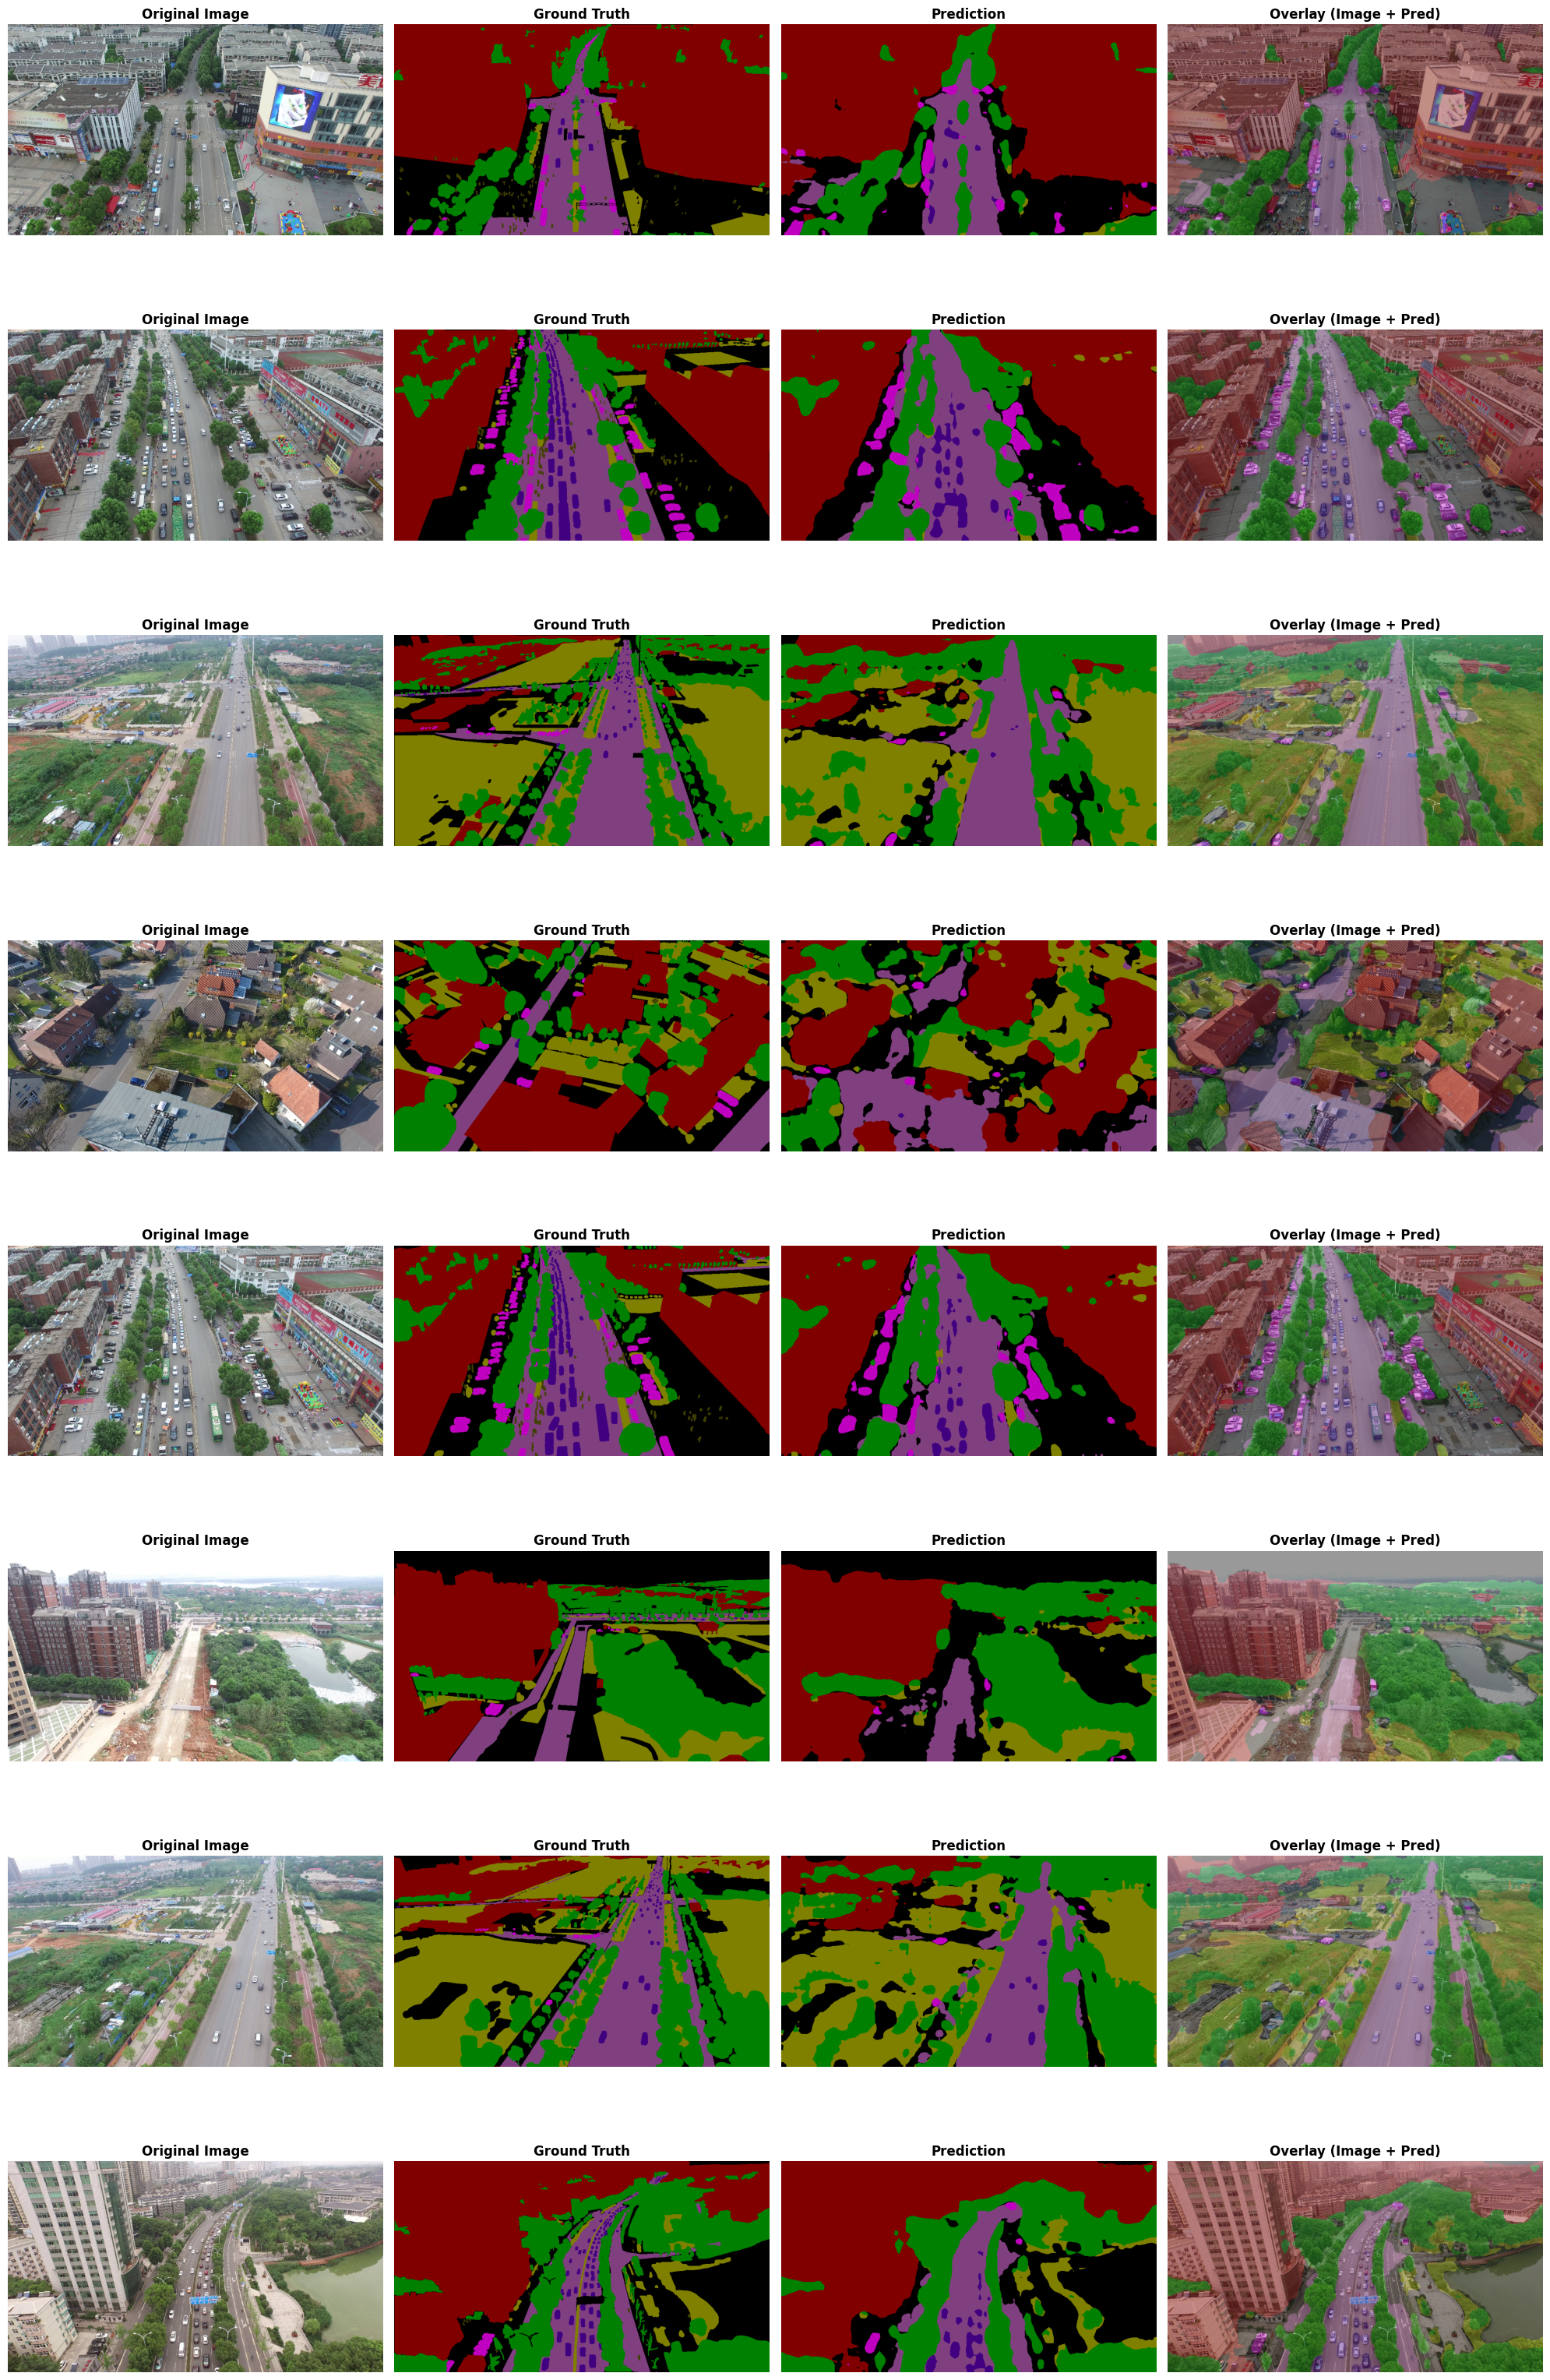

In [16]:
visualize_inference(
    model=model_deeplab,
    dataloader=loader,
    device=device,
    reversed_mapping=reversed_mapping,
    num_samples=8
)

In [18]:
checkpoint_dir

'/teamspace/studios/this_studio/ray_results/train_deeplab_2025-11-30_16-07-01/train_deeplab_9fd33_00003_3_accumulation_steps=8,batch_size=2,lr=0.0114,weight_decay=0.0000_2025-11-30_16-07-09'

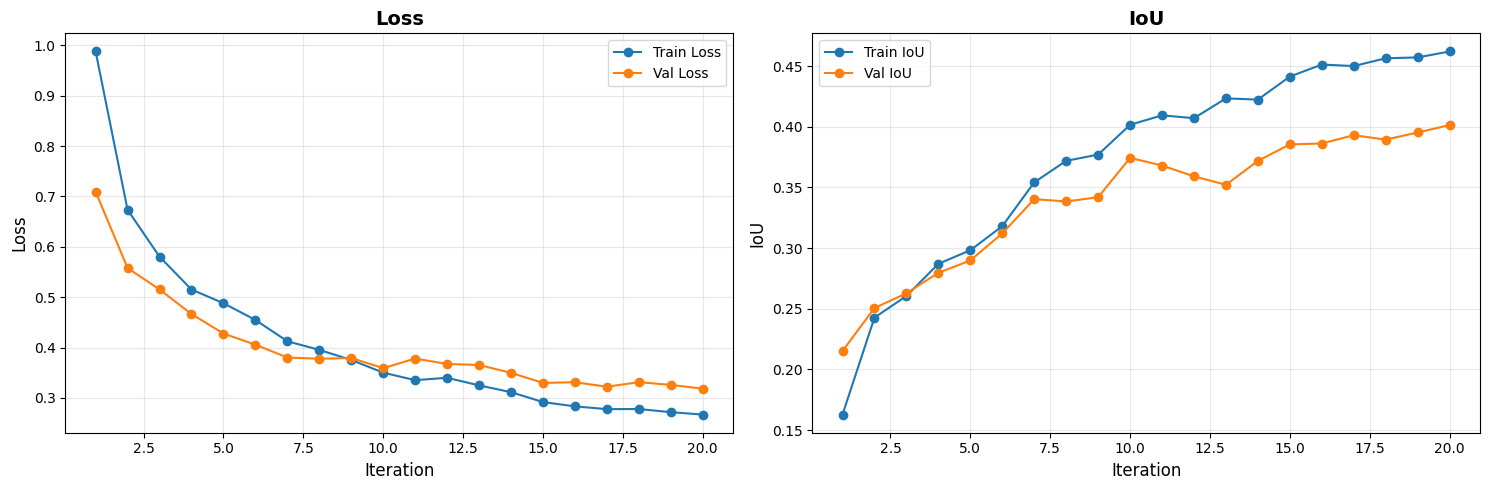

In [19]:
plot_best_trial_metrics(
    f"{checkpoint_dir}/progress.csv"
)

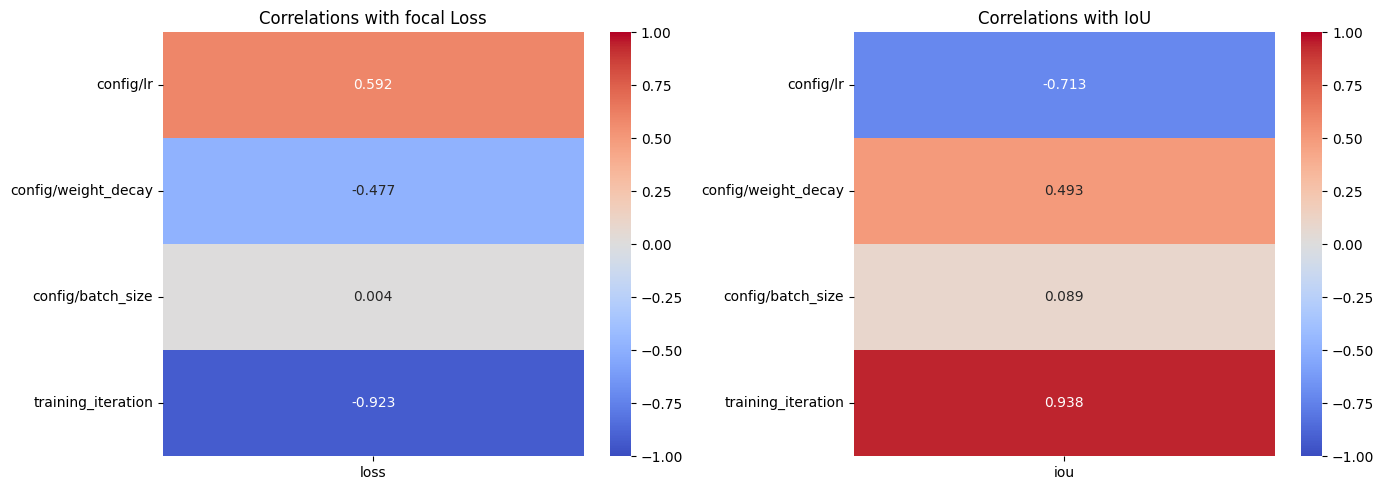

In [23]:
analysis = ExperimentAnalysis("/".join(checkpoint_dir.split("/")[:-1]))

results_df = analysis.dataframe()

param_cols = ['config/lr', 'config/weight_decay', 'config/batch_size', 'training_iteration']

results_clean = results_df[param_cols + ['loss', 'iou']].dropna()

results_clean['config/batch_size'] = results_clean['config/batch_size'].astype(float)

corr_matrix = results_clean.corr()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(corr_matrix[['loss']].iloc[:-2], annot=True, fmt='.3f', cmap='coolwarm', ax=axes[0], vmin=-1, vmax=1, center=0)
axes[0].set_title('Correlations with focal Loss')

sns.heatmap(corr_matrix[['iou']].iloc[:-2], annot=True, fmt='.3f', cmap='coolwarm', ax=axes[1], vmin=-1, vmax=1, center=0)
axes[1].set_title('Correlations with IoU')

plt.tight_layout()
plt.show()